# Logistic regression model

In [1]:
# Standard library imports
from typing import Tuple

# PyPI imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Input data
data_file='../data/resampled_disaster_data_all.parquet'

## 1. Data loading

In [2]:
data_df=pd.read_parquet(data_file)
data_df.head()

,state,Coastal Storm,Fire,Flood,Hurricane,Severe Storm,Tornado,Typhoon,Winter weather,No incident,year,month
0,AK,0,0,0,0,0,0,0,0,1,1953,10
1,AK,0,0,0,0,0,0,0,0,1,1953,11
2,AK,0,0,0,0,0,0,0,0,1,1953,12
3,AK,0,0,0,0,0,0,0,0,1,1954,1
4,AK,0,0,0,0,0,0,0,0,1,1954,2


In [3]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43639 entries, 0 to 43638
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   state           43639 non-null  object
 1   Coastal Storm   43639 non-null  int64 
 2   Fire            43639 non-null  int64 
 3   Flood           43639 non-null  int64 
 4   Hurricane       43639 non-null  int64 
 5   Severe Storm    43639 non-null  int64 
 6   Tornado         43639 non-null  int64 
 7   Typhoon         43639 non-null  int64 
 8   Winter weather  43639 non-null  int64 
 9   No incident     43639 non-null  int64 
 10  year            43639 non-null  int64 
 11  month           43639 non-null  int64 
dtypes: int64(11), object(1)
memory usage: 4.0+ MB


In [4]:
print(f"Severe storms: {data_df['Severe Storm'].sum()}")
print(f"Hurricanes: {data_df['Hurricane'].sum()}")
print(f"Floods: {data_df['Flood'].sum()}")

Severe storms: 982
Hurricanes: 319
Floods: 839


## 2. Data preparation

### 2.1. Create multiindex

In [5]:
indexes=[
    data_df['year'].tolist(),
    data_df['state'].tolist(),
    data_df['month'].tolist()
]

index_tuples=list(zip(*indexes))
index=pd.MultiIndex.from_tuples(index_tuples, names=['Year', 'State', 'Month'])
data_df.set_index(index, inplace=True)
data_df.head()

state  Coastal Storm  Fire  Flood  Hurricane  Severe Storm  \
Year State Month                                                              
1953 AK    10       AK              0     0      0          0             0   
           11       AK              0     0      0          0             0   
           12       AK              0     0      0          0             0   
1954 AK    1        AK              0     0      0          0             0   
           2        AK              0     0      0          0             0   

                  Tornado  Typhoon  Winter weather  No incident  year  month  
Year State Month                                                              
1953 AK    10           0        0               0            1  1953     10  
           11           0        0               0            1  1953     11  
           12           0        0               0            1  1953     12  
1954 AK    1            0        0               0            1  1954      1  
           2            0        0               0            1  1954      2

### 2.2. Cyclical month encoding

In [6]:
# # Don't worry about downcasting FutureWarning
# pd.set_option('future.no_silent_downcasting', True)

# Define a helper function here so we can encode the time
# features the same way on the training and testing data
# without copy-pasting the same code
def encode_month(data_df: pd.DataFrame) -> pd.DataFrame:
    '''Takes a Pandas dataframe and uses cyclical sin/cos to encode
    month feature. Returns updated dataframe.'''

    data_df['month_sin'] = np.sin(2 * np.pi * data_df['month']/12.0)
    data_df['month_cos'] = np.cos(2 * np.pi * data_df['month']/12.0)

    # Drop the original string features
    data_df.drop(['month'], axis=1, inplace=True)

    return data_df

In [7]:
data_df=encode_month(data_df)
data_df.head()

state  Coastal Storm  Fire  Flood  Hurricane  Severe Storm  \
Year State Month                                                              
1953 AK    10       AK              0     0      0          0             0   
           11       AK              0     0      0          0             0   
           12       AK              0     0      0          0             0   
1954 AK    1        AK              0     0      0          0             0   
           2        AK              0     0      0          0             0   

                  Tornado  Typhoon  Winter weather  No incident  year  \
Year State Month                                                        
1953 AK    10           0        0               0            1  1953   
           11           0        0               0            1  1953   
           12           0        0               0            1  1953   
1954 AK    1            0        0               0            1  1954   
           2            0        0               0            1  1954   

                     month_sin  month_cos  
Year State Month                           
1953 AK    10    -8.660254e-01   0.500000  
           11    -5.000000e-01   0.866025  
           12    -2.449294e-16   1.000000  
1954 AK    1      5.000000e-01   0.866025  
           2      8.660254e-01   0.500000

### 2.2. Dummy encode state

Can't decide if I want this one or not - for actual timeseries models, the state will never change in a batch. But for simple logistic regression, it might be useful to have it. Let's do it, we can always just drop the columns later if we decide we don't want it.

In [8]:
# states=pd.get_dummies(data_df['state'], dtype=int)
# states.head()

In [9]:
# # Combine the state dummies and the original dataframe and remove the 'state' column
# data_df=pd.concat([data_df, states], axis=1)
data_df.drop('state', axis=1, inplace=True)
# data_df.head()

### 2.3. Collapse incident types

In [10]:
print(f"Severe storms: {data_df['Severe Storm'].sum()}")
print(f"Hurricanes: {data_df['Hurricane'].sum()}")
print(f"Floods: {data_df['Flood'].sum()}")

Severe storms: 982
Hurricanes: 319
Floods: 839


In [11]:
# Sum our columns of interest and add the result as a new 'incident' feature
incidents=data_df['Severe Storm']+data_df['Hurricane']+data_df['Flood']+data_df['Coastal Storm']
data_df['incident']=incidents

# Clip the new incident feature at 1
data_df['incident']=data_df['incident'].clip(upper=1)

# Drop the old individual incident columns
data_df.drop(['Coastal Storm','Fire','Flood','Hurricane','Severe Storm','Tornado','Typhoon','Winter weather','No incident'], axis=1, inplace=True)
data_df.head()

year     month_sin  month_cos  incident
Year State Month                                         
1953 AK    10     1953 -8.660254e-01   0.500000         0
           11     1953 -5.000000e-01   0.866025         0
           12     1953 -2.449294e-16   1.000000         0
1954 AK    1      1954  5.000000e-01   0.866025         0
           2      1954  8.660254e-01   0.500000         0

In [14]:
data_df.loc[:,'AK',:]

year     month_sin     month_cos  incident
Year Month                                            
1953 10     1953 -8.660254e-01  5.000000e-01         0
     11     1953 -5.000000e-01  8.660254e-01         0
     12     1953 -2.449294e-16  1.000000e+00         0
1954 1      1954  5.000000e-01  8.660254e-01         0
     2      1954  8.660254e-01  5.000000e-01         0
...          ...           ...           ...       ...
2022 5      2022  5.000000e-01 -8.660254e-01         1
     6      2022  1.224647e-16 -1.000000e+00         0
     7      2022 -5.000000e-01 -8.660254e-01         0
     8      2022 -8.660254e-01 -5.000000e-01         0
     9      2022 -1.000000e+00 -1.836970e-16         1

[828 rows x 4 columns]

### 2.4. Batch data

In [15]:
def generate_data(data_df: pd.DataFrame, input_window: int) -> Tuple[np.array, np.array]:
    '''Takes dataframe, input window size, parses data into feature label pairs,
    returns as tuple of numpy arrays'''

    # Get list of states
    states=data_df.index.get_level_values('State').unique().tolist()

    features=[]
    labels=[]

    # Loop on states
    for state in states:

        # Extract the data for this state
        state_df=data_df.loc[:,state,:]

        # Indexing variable for batch
        input_start_index=0

        # Loop on the state data
        while input_start_index + input_window + 1 < len(state_df):

            # Extract and collect the features and labels
            feature_row=state_df.iloc[input_start_index:input_start_index + input_window, :]
            label_row=state_df.iloc[input_start_index + input_window, -1]
            features.append(feature_row.values.tolist())
            labels.append(label_row)

            # Update the index
            input_start_index+=input_window + 1

    # Convert to numpy arrays
    features=np.array(features)
    labels=np.array(labels)

    # Squeeze out the extra dimension for window width of 1
    if input_window == 1:
        features=features.squeeze(axis=1)

    return features, labels

In [16]:
# Generate some feature, label pairs
input_window=1
features, labels=generate_data(data_df, input_window)

### 2.5. Train-test split

In [17]:
# Split them into training and validation
training_features, testing_features, training_labels, testing_labels=train_test_split(features, labels)

print(f'Training features: {training_features.shape}')
print(f'Training labels: {training_labels.shape}, {(sum(training_labels)/len(training_labels))*100:.1f}% positive class')
print(f'Testing features: {testing_features.shape}')
print(f'Testing labels: {testing_labels.shape}, {(sum(testing_labels)/len(testing_labels))*100:.1f}% positive class')

Training features: (16329, 4)
Training labels: (16329,), 4.7% positive class
Testing features: (5443, 4)
Testing labels: (5443,), 4.9% positive class


### 2.6. Standardize features

In [18]:
# Scale the data
scaler=StandardScaler()
scaler.fit(training_features)
training_features=scaler.transform(training_features)
testing_features=scaler.transform(testing_features)

## 3. Logistic regression model

### 3.1. Fit the model on the training data

In [19]:
model=LogisticRegression(class_weight='balanced', random_state=315).fit(training_features, training_labels)

### 3.2. Evaluate the model on the test data

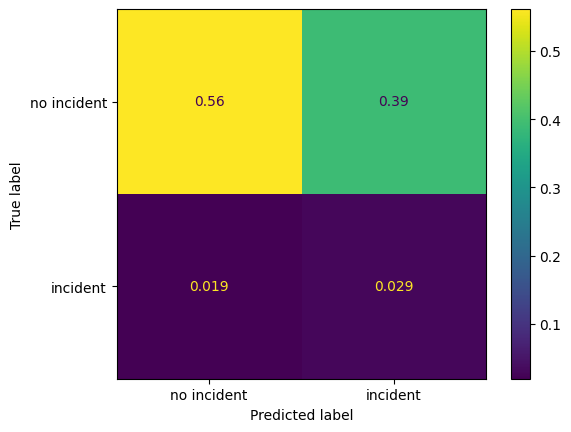

In [20]:
predictions=model.predict(testing_features)
cm=confusion_matrix(testing_labels, predictions, normalize='all')
cm_disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['no incident', 'incident'])
_=cm_disp.plot()

Not great - we have about 40% false negatives, which means we are missing a lot of disasters! Let's try a better model.

## 4. LSTM model

### 4.1. Data preparation

In [29]:
# Generate feature, label pairs
input_window=24
features, labels=generate_data(data_df, input_window)

# Split them into training and validation
training_features, testing_features, training_labels, testing_labels=train_test_split(features, labels)

print(f'Training features: {training_features.shape}')
print(f'Training labels: {training_labels.shape}, {(sum(training_labels)/len(training_labels))*100:.1f}% positive class')
print(f'Testing features: {testing_features.shape}')
print(f'Testing labels: {testing_labels.shape}, {(sum(testing_labels)/len(testing_labels))*100:.1f}% positive class')


Training features: (1288, 24, 4)
Training labels: (1288,), 4.5% positive class
Testing features: (430, 24, 4)
Testing labels: (430,), 3.3% positive class


In [30]:
pos_examples=training_labels.sum()
neg_examples=len(training_labels) - pos_examples
print(f'Training data has {pos_examples} positive examples and {neg_examples} negative examples.')

# Class weighting scheme suggested in the Keras documentation
# pos_class_weight=1 / training_labels.sum()
# neg_class_weight=1/ (len(training_labels) - training_labels.sum())

# Class weighting scheme suggested in a Tensorflow tutorial
neg_class_weight = (1 / neg_examples) * (len(training_labels) / 2.0)
pos_class_weight = (1 / pos_examples) * (len(training_labels) / 2.0)
class_weight = {0: neg_class_weight, 1: pos_class_weight}
print(f'Class weights: {class_weight}')

initial_bias=np.log([pos_examples/neg_examples])
print(f'Initial bias: {initial_bias}')

Training data has 58 positive examples and 1230 negative examples.
Class weights: {0: np.float64(0.5235772357723577), 1: np.float64(11.10344827586207)}
Initial bias: [-3.05432644]


In [62]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

output_bias=keras.initializers.Constant(initial_bias)

model=Sequential()
model.add(layers.Input((input_window,4)))
model.add(layers.LSTM(256))
# model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))#, bias_initializer=output_bias))

# Define the optimizer
optimizer=keras.optimizers.Adam(learning_rate=0.00001)

# Compile the model, specifying the type of loss to use during training and any extra
# metrics to evaluate
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['true_positives', 'false_positives', 'false_negatives'])

In [63]:
result=model.fit(
    training_features,
    training_labels,
    validation_data=(testing_features, testing_labels),
    epochs=50,
    batch_size=256,
    verbose=1,
    class_weight=class_weight
)

Epoch 1/50


6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 268ms/step - false_negatives: 0.0000e+00 - false_positives: 875.1429 - loss: 0.7087 - true_positives: 41.4286 - val_false_negatives: 0.0000e+00 - val_false_positives: 416.0000 - val_loss: 0.8783 - val_true_positives: 14.0000
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 202ms/step - false_negatives: 0.0000e+00 - false_positives: 875.1429 - loss: 0.7138 - true_positives: 41.4286 - val_false_negatives: 0.0000e+00 - val_false_positives: 416.0000 - val_loss: 0.8668 - val_true_positives: 14.0000
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 212ms/step - false_negatives: 0.0000e+00 - false_positives: 876.0000 - loss: 0.6963 - true_positives: 40.5714 - val_false_negatives: 0.0000e+00 - val_false_positives: 416.0000 - val_loss: 0.8557 - val_true_positives: 14.0000
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 183ms/step - false_negatives: 0.0000e+00 - false_positives: 873.8571 - loss: 0.7226 - true_positives: 42.7143 - val_false_negatives: 0.0000e+00 - val_false_positives: 416.0000 - va

In [65]:
# Define a re-useable helper function that plots the results of a single training run
def plot_single_training_run(training_results):
    '''Takes a training results dictionary, plots it.'''

    # Set-up a 2x2 figure for metrics
    fig, axs=plt.subplots(2,2, figsize=(8,8))
    axs=axs.flatten()

    # Add the main title
    fig.suptitle('CNN training curves', size='large')

    # Plot training and validation binary cross-entropy
    axs[0].set_title('Binary cross-entropy')
    axs[0].plot(training_results.history['loss'], label='Training')
    axs[0].plot(training_results.history['val_loss'], label='Validation')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Binary cross-entropy')
    axs[0].legend(loc='upper left')

    # Plot training and validation true positives
    axs[1].set_title('True positives')
    axs[1].plot(training_results.history['true_positives'])
    axs[1].plot(training_results.history['val_true_positives'])
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('True positives')

    # Plot training and validation false negatives
    axs[2].set_title('False negatives')
    axs[2].plot(training_results.history['false_negatives'])
    axs[2].plot(training_results.history['val_false_negatives'])
    axs[2].set_xlabel('Epoch')
    axs[2].set_ylabel('False negatives')

    # Plot training and validation false positives
    axs[3].set_title('False positives')
    axs[3].plot(training_results.history['false_positives'])
    axs[3].plot(training_results.history['val_false_positives'])
    axs[3].set_xlabel('Epoch')
    axs[3].set_ylabel('False positives')

    # Show the plot
    plt.tight_layout()

    return plt

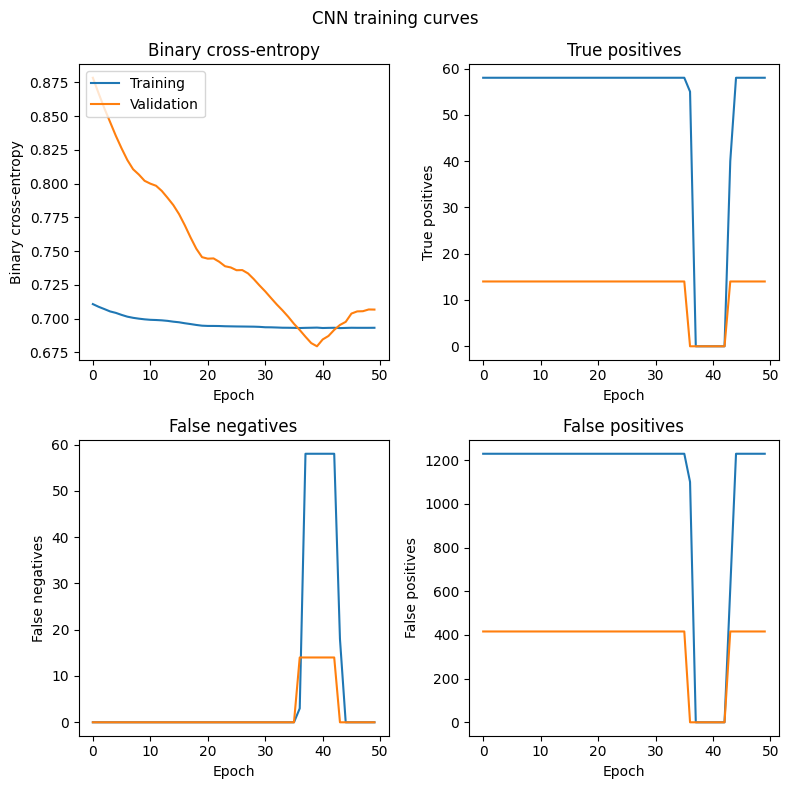

In [66]:
plot_single_training_run(result).show()

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


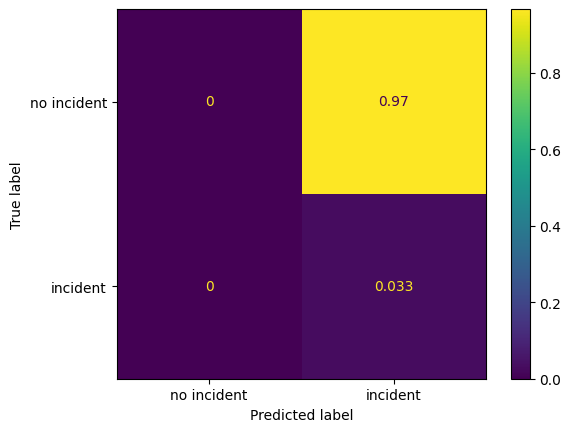

In [67]:
predictions=model.predict(testing_features)

threshold=0.5
cm=confusion_matrix(testing_labels, predictions > threshold, normalize='all')
cm_disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['no incident', 'incident'])
_=cm_disp.plot()